# Licences / Notes

In [1]:
# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#Adapted by Thierry Lincoln in November,2019 from this Colab notebook:
#https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb.
#Changes includes 

# - Reading our stressor data and parsing it properly
# - reconfiguring the last layer to include N neurons corresponding to N categories
# - correcting the probability output so that it follows [0,1] proper pattern 
# - better analysis with confusion matrix
# - exporting to pb format for tensorflow serving api

Intro:

If you’ve been following Natural Language Processing over the past year, you’ve probably heard of BERT: Bidirectional Encoder Representations from Transformers. It’s a neural network architecture designed by Google researchers that’s totally transformed what’s state-of-the-art for NLP tasks, like text classification, translation, summarization, and question answering.

Now that BERT's been added to [TF Hub](https://www.tensorflow.org/hub) as a loadable module, it's easy(ish) to add into existing Tensorflow text pipelines. In an existing pipeline, BERT can replace text embedding layers like ELMO and GloVE. Alternatively, [finetuning](http://wiki.fast.ai/index.php/Fine_tuning) BERT can provide both an accuracy boost and faster training time in many cases.

Some code was adapted from [this colab notebook](https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb). Let's get started!

# Loading Libraries

In [3]:
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/lib'
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #(or "1" or "2")

In [4]:
import sys
print(sys.executable)

/commuter/thierrylincoln/Tf1.1_py36/bin/python3.6


In [5]:
#export LD_LIBRARY_PATH=/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/lib
#export CUDA_VISIBLE_DEVICES=0

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score,confusion_matrix,classification_report,accuracy_score


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

In [7]:
print(tf.__version__) #needs to be version 1.15.0, version 2.0 doesn't work with this notebook

1.15.0


In [1]:

config = tf.ConfigProto()
#config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
#config.gpu_options.visible_device_list="0"



from tensorflow.python.client import device_lib

device_lib.list_local_devices()

NameError: name 'tf' is not defined

In addition to the standard libraries we imported above, we'll need to install BERT's python package.

In [9]:
#!pip install bert-tensorflow

In [10]:
import bert
from bert import run_classifier_with_tfhub
from bert import optimization
from bert import tokenization
import numpy as np


Below, we'll set an output directory location to store our model output and checkpoints. This can be a local directory, in which case you'd set OUTPUT_DIR to the name of the directory you'd like to create. 


Set DO_DELETE to rewrite the OUTPUT_DIR if it exists. Otherwise, Tensorflow will load existing model checkpoints from that directory (if they exist).

## Utils functions 

In [11]:
def f(x):
    n = 2  # index of the second proability to get labeled 

    index = np.argsort(x.values.flatten().tolist())[-n:][0]
    print(f"index is {index}")
    label  = label_list_text[index]
    print(f"label is {label}")
    
    return label
    

In [12]:
final_columns = ["sOrder","Input.text","is_stressor","is_stressor_conf","top_label","second_label","Branch", "Above SD-THRESHOLD","SD-THRESHOLD","SD","Other","Everyday Decision Making","Work","Social Relationships","Financial Problem","Health, Fatigue, or Physical Pain","Emotional Turmoil","Family Issues","School","avg_severity","median_severity","SD_severity","Votes","Source"]

In [13]:
def get_test_experiment_df(test):
    test_predictions = [x[0]['probabilities'] for x in zip(getListPrediction(in_sentences=list(test[DATA_COLUMN])))]
    test_live_labels = np.array(test_predictions).argmax(axis=1)
    test['Predicted'] = [label_list_text[x] for x in test_live_labels] # appending the labels to the dataframe

    probabilities_df_live = pd.DataFrame(test_predictions) # creating a proabilities dataset
    probabilities_df_live.columns = label_list_text # naming the columns

    test.reset_index(inplace=True,drop=True) # resetting index 

    experiment_df = pd.concat([test,probabilities_df_live],axis=1, ignore_index=False)
    return test,experiment_df

In [14]:
def get_test_experiment_df_formatted(test):
    test_predictions = [x[0]['probabilities'] for x in zip(getListPrediction(in_sentences=list(test[DATA_COLUMN])))]
    test_live_labels = np.array(test_predictions).argmax(axis=1)
    test[LABEL_COLUMN_RAW] = [label_list_text[x] for x in test_live_labels] # appending the labels to the dataframe
    
    probabilities_df_live = pd.DataFrame(test_predictions) # creating a proabilities dataset
    probabilities_df_live.columns = [x for x in label_list_text] # naming the columns
    probabilities_df_live['second_label'] = probabilities_df_live.apply(lambda x:f(x),axis=1)
    
    #print(test)
    #label_df = create_examples_prediction(test)
    #label_df.columns = label_list_text
    #label_df['label 2'] = label_df.apply(lambda x:f(x),axis=1)

    test.reset_index(inplace=True,drop=True) # resetting index 
    
    test_removed_columns =  list(set(test.columns)-set(probabilities_df_live.columns))
    
    test_temp = test[test_removed_columns]
    
    experiment_df = pd.concat([test_temp,probabilities_df_live],axis=1, ignore_index=False)
    
    
    missing_cols = list(set(experiment_df.columns)-set(final_columns))
    experiment_df[missing_cols] = np.nan#.loc[:, missing_cols] = np.nan
    
    print(experiment_df.head(10))
    
    experiment_df = experiment_df.reindex(columns = final_columns)

    
    #experiment_df = experiment_df.reindex(sorted(experiment_df.columns), axis=1)
    
    return test,experiment_df

In [15]:
def getListPrediction(in_sentences):
    #1
    input_examples = [bert.run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
    
    #2
    input_features = bert.run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
    
    #3
    predict_input_fn = bert.run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
    
    print(input_features[0].input_ids)
    #4
    predictions = estimator.predict(input_fn=predict_input_fn,yield_single_examples=True)
    
    return predictions

In [16]:
is_normalize_active=False

def get_confusion_matrix(y_test,predicted,labels):
    class_names=labels
    # plotting confusion matrix
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, predicted, classes=class_names,
                        title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, predicted, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')
    plt.show()
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes =classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        test =1
        #print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax


# Loading the data

In [17]:
def data_prep_bert(df,test_size):
    
    print("Filling missing values")
    df[DATA_COLUMN] = df[DATA_COLUMN].fillna('_NA_')
    
    print("Splitting dataframe with shape {} into training and test datasets".format(df.shape))
    X_train, X_test  = train_test_split(df, test_size=test_size, random_state=2018,stratify = df[LABEL_COLUMN_RAW])

    return X_train, X_test


In [18]:
def open_dataset(NAME,mapping_index,excluded_categories):
    df = pd.read_csv(PATH+NAME+'.csv',sep =',')
    df.head(10)
    df = df[df[LABEL_COLUMN_RAW].notna()]
    
    
    
    #df.columns = [LABEL_COLUMN_RAW,'Severity',DATA_COLUMN,'Source']
    
    if excluded_categories is not None:
        for category in excluded_categories:

            df = df[df[LABEL_COLUMN_RAW] !=category]

    label_list=[]
    label_list_final =[]
    if(mapping_index is None):
        df[LABEL_COLUMN_RAW] = df[LABEL_COLUMN_RAW].astype('category')
        df[LABEL_COLUMN], mapping_index = pd.Series(df[LABEL_COLUMN_RAW]).factorize() #uses pandas factorize() to convert to numerical index
        
        
        
        label_list_final = [None] * len(mapping_index.categories)
        label_list_number = [None] * len(mapping_index.categories)
        
        for index,ele in enumerate(list(mapping_index.categories)):
            lindex = mapping_index.get_loc(ele)
            label_list_number[lindex] = lindex
            label_list_final[lindex] = ele
    else:
        df[LABEL_COLUMN] = df[LABEL_COLUMN_RAW].apply(lambda x: mapping_index.get_loc(x))
    
    frequency_dict = df[LABEL_COLUMN_RAW].value_counts().to_dict()
    df["class_freq"] = df[LABEL_COLUMN_RAW].apply(lambda x: frequency_dict[x])
    
    
    return df,mapping_index,label_list_number,label_list_final
    

# Require user changes > Start Here 

### Experiment Name

In [19]:
PATH = './datasets/'
TODAY_DATE = "02_07_2020/"
EXPERIMENT_NAME = 'test_covid'
EXPERIMENTS_PATH = PATH + 'experiments/'+TODAY_DATE+EXPERIMENT_NAME
if not os.path.exists(PATH + 'experiments/'+TODAY_DATE):
    os.mkdir(PATH + 'experiments/'+TODAY_DATE)
if not os.path.exists(EXPERIMENTS_PATH):
    os.mkdir(EXPERIMENTS_PATH)

### Model Hyperparameters

In [20]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 100

# We'll set sequences to be at most 32 tokens long.
MAX_SEQ_LENGTH = 32


OUTPUT_DIR = './models/'+ TODAY_DATE+EXPERIMENT_NAME+'/'

In [21]:

DATASET_NAME = '2020-06-08-MainTurkAggregation-5-Turkers_v0'

DATA_COLUMN = 'Input.text'
LABEL_COLUMN_RAW = 'is_covid'#'Answer.Label'
LABEL_COLUMN = 'is_covid'

MTURK_NAME = 'mTurk_synthetic'
LIVE_NAME = 'popbots_live'
INQUIRE_NAME = 'Inquire'
MTURK_COVID_NAME = 'mTurk_synthetic_covid'


#dataset,mapping_index,label_list, label_list_text = open_dataset('mturk900balanced',None)

EXCLUDED_CATEGORIES = None #['Other'] #None # # if nothing to exclude put None, THIS ALWAYS MUST BE A LIST 

dataset,mapping_index,label_list, label_list_text = open_dataset(DATASET_NAME,None,EXCLUDED_CATEGORIES)


test_on_mturk_and_popbots_live = False # include live data in training + include mturk in testing


if test_on_mturk_and_popbots_live:
    mturk = dataset[(dataset['Source']== MTURK_NAME) | (dataset['Source']== MTURK_COVID_NAME)| (dataset['Source']== 'mTurk_synthetic_covid_2')]
    live = dataset[dataset['Source']== LIVE_NAME]
    live = live.sample(frac=1).reset_index(drop=True) # shuffle live
    PERCENTAGE_LIVE_TEST = 150
    
    TEST_PERCENTAGE = len(live)/((100/PERCENTAGE_LIVE_TEST)*len(mturk))  # given to set the percentage of mturk used as test set to have 50/50
    
    print(f"Test percentage is {TEST_PERCENTAGE}")

    train,test = data_prep_bert(mturk,TEST_PERCENTAGE) # test size from mturk 
    
    train = train.append(live.loc[0:int((1-(PERCENTAGE_LIVE_TEST/100))*len(live))]) # taking 1/2 of that dataset for training
    #train = train.append(dataset[dataset['Source'] == INQUIRE_NAME] )
    test = test.append(live.loc[int(len(live)*(1-(PERCENTAGE_LIVE_TEST/100))):int(len(live))]) # taking 1/2 of live dataset for testing
else:
    # or taking live only for testing
    train= dataset
    test = dataset[(dataset['Source'] == 'popbots_live') | (dataset['Source']== 'mTurk_synthetic_covid_2' )] 

#print(f"Dataset has {len(dataset)} training examples")
print(f"Normal label list is {label_list}")
print(f"The labels text is {label_list_text}")

#Export train test to csv
#train.to_csv(PATH+'900_CSV_SPLITTED/train.csv')
#test.to_csv(PATH+'900_CSV_SPLITTED/test.csv')

Normal label list is [0, 1]
The labels text is [0, 1]


### Train set and test set analysis

In [22]:
def print_dataset_info(train,test):
    print(f"Train size {len(train)} with {len(train[train['Source']== 'Popbots'])} from Popbots and {len(train[train['Source']== 'mTurk'])} from mturk")
    print(f"Test size {len(test)} with {len(test[test['Source']== 'Popbots'])} from Popbots and {len(test[test['Source']== 'mTurk'])} from mturk")
    
    print('\nTraining distribution:')
    print(pd.pivot_table(train[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=True)
          
    print('\nTesting distribution:')
    print(pd.pivot_table(test[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=True)

In [23]:
train = train.sample(frac=1).reset_index(drop=True) #reshuffle everything
test = test.sample(frac=1).reset_index(drop=True)

In [24]:
print('\nAll dataset distribution:')
print(pd.pivot_table(dataset[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=T


All dataset distribution:
is_covid  Source                 
0         Inquire                     524
          mTurk_synthetic            2014
          mTurk_synthetic_covid       383
          mTurk_synthetic_covid_2      89
          popbots_live                185
1         mTurk_synthetic_covid       615
          mTurk_synthetic_covid_2      61
dtype: int64


In [30]:
print_dataset_info(train,test)

Train size 3871 with 0 from Popbots and 0 from mturk
Test size 335 with 0 from Popbots and 0 from mturk

Training distribution:
is_covid  Source                 
0         Inquire                     524
          mTurk_synthetic            2014
          mTurk_synthetic_covid       383
          mTurk_synthetic_covid_2      89
          popbots_live                185
1         mTurk_synthetic_covid       615
          mTurk_synthetic_covid_2      61
dtype: int64

Testing distribution:
is_covid  Source                 
0         mTurk_synthetic_covid_2     89
          popbots_live               185
1         mTurk_synthetic_covid_2     61
dtype: int64


### Step to reduce the most dominant categories and balance the dataset

In [175]:
sampling_cutoff = 100 # all the categories which had less than 100 example won't be sampled down
total_training_size = 1501

REVERSE_FREQ = 'Max_reverse_sampling_chance'
train[REVERSE_FREQ] = train['class_freq'].apply(lambda x: (max(train['class_freq'])/x)*(max(train['class_freq'])/x)) 

sampling_boolean = (train['Source'] != 'Popbots') & (train['class_freq'].astype(float) > sampling_cutoff) 


train_to_be_balanced = train[sampling_boolean]
train_not_resampled = train[~sampling_boolean]

train_temp = train_to_be_balanced.sample(n=(total_training_size-len(train_not_resampled)), weights=REVERSE_FREQ, random_state=2020)
train = pd.concat([train_temp,train_not_resampled])

In [176]:
print_dataset_info(train,test)

Train size 1501 with 93 from Popbots and 1408 from mturk
Test size 186 with 93 from Popbots and 93 from mturk

Training distribution:
Consolidated Updated Categories  Source 
Emotional Turmoil                Popbots      2
                                 mTurk      203
Everyday Decision Making         mTurk       59
Family Issues                    Popbots      4
                                 mTurk      224
Financial Problem                Popbots      4
                                 mTurk      296
Health or Physical Pain          Popbots     15
                                 mTurk      141
Other                            Popbots     18
                                 mTurk       96
School                           Popbots      9
                                 mTurk      131
Social Relationships             Popbots     12
                                 mTurk       34
Work                             Popbots     29
                                 mTurk      224
dtype: in

In [237]:
train = train.sample(frac=1).reset_index(drop=True) #reshuffle everything

In [238]:
mapping_index.categories

Int64Index([0, 1], dtype='int64')

In [260]:
train.to_csv(EXPERIMENTS_PATH+'/TRAIN_'+DATASET_NAME+'.csv')
test.to_csv(EXPERIMENTS_PATH+'/TEST_'+DATASET_NAME+'.csv')

In [45]:
train = pd.read_csv('./datasets/experiments/24_06_2020/newly_labelled/TRAIN_2020-06-20-MainTurkAggregation-5-Turkers_v0.csv')
test = pd.read_csv('./datasets/experiments/24_06_2020/newly_labelled/TEST_2020-06-20-MainTurkAggregation-5-Turkers_v0.csv')

# Require user changes > STOP Here 

# Data Preprocessing

For us, our input data is the 'sentence' column and our label is the 'polarity' column 

#Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [25]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Next, we need to preprocess our data so that it matches the data BERT was 

1.   List item
2.   List item

trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Happily, we don't have to worry about most of these details.




To start, we'll need to load a vocabulary file and lowercasing information directly from the BERT tf hub module:

In [26]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"#"https://tfhub.dev/digitalepidemiologylab/covid-twitter-bert/1"#

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Great--we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:

In [27]:
tokenizer.tokenize("covid-19")

['co', '##vid', '-', '19']

Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands.

In [28]:

# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 3871


INFO:tensorflow:Writing example 0 of 3871


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] honestly , organizing social situations when most people are out of town or busy [SEP]


INFO:tensorflow:tokens: [CLS] honestly , organizing social situations when most people are out of town or busy [SEP]


INFO:tensorflow:input_ids: 101 9826 1010 10863 2591 8146 2043 2087 2111 2024 2041 1997 2237 2030 5697 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 9826 1010 10863 2591 8146 2043 2087 2111 2024 2041 1997 2237 2030 5697 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the constant pain bothered me and considering that several cow ##or ##kers have been sick with flu , sw ##ine flu , and st ##re ##p throat , i thought [SEP]


INFO:tensorflow:tokens: [CLS] the constant pain bothered me and considering that several cow ##or ##kers have been sick with flu , sw ##ine flu , and st ##re ##p throat , i thought [SEP]


INFO:tensorflow:input_ids: 101 1996 5377 3255 11250 2033 1998 6195 2008 2195 11190 2953 11451 2031 2042 5305 2007 19857 1010 25430 3170 19857 1010 1998 2358 2890 2361 3759 1010 1045 2245 102


INFO:tensorflow:input_ids: 101 1996 5377 3255 11250 2033 1998 6195 2008 2195 11190 2953 11451 2031 2042 5305 2007 19857 1010 25430 3170 19857 1010 1998 2358 2890 2361 3759 1010 1045 2245 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] my stress timing is loss of many things . [SEP]


INFO:tensorflow:tokens: [CLS] my stress timing is loss of many things . [SEP]


INFO:tensorflow:input_ids: 101 2026 6911 10984 2003 3279 1997 2116 2477 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2026 6911 10984 2003 3279 1997 2116 2477 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i have to choose between stress ##ful ##l well - paid job and a better job with pay cut . [SEP]


INFO:tensorflow:tokens: [CLS] i have to choose between stress ##ful ##l well - paid job and a better job with pay cut . [SEP]


INFO:tensorflow:input_ids: 101 1045 2031 2000 5454 2090 6911 3993 2140 2092 1011 3825 3105 1998 1037 2488 3105 2007 3477 3013 1012 102 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2031 2000 5454 2090 6911 3993 2140 2092 1011 3825 3105 1998 1037 2488 3105 2007 3477 3013 1012 102 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i need to find a new job ! [SEP]


INFO:tensorflow:tokens: [CLS] i need to find a new job ! [SEP]


INFO:tensorflow:input_ids: 101 1045 2342 2000 2424 1037 2047 3105 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2342 2000 2424 1037 2047 3105 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 0 of 335


INFO:tensorflow:Writing example 0 of 335


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hey dude evening free [SEP]


INFO:tensorflow:tokens: [CLS] hey dude evening free [SEP]


INFO:tensorflow:input_ids: 101 4931 12043 3944 2489 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4931 12043 3944 2489 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i just miss seeing my friends because of corona ##virus [SEP]


INFO:tensorflow:tokens: [CLS] i just miss seeing my friends because of corona ##virus [SEP]


INFO:tensorflow:input_ids: 101 1045 2074 3335 3773 2026 2814 2138 1997 21887 23350 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2074 3335 3773 2026 2814 2138 1997 21887 23350 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] my work has been stress ##ing me lately . i now have to work from home [SEP]


INFO:tensorflow:tokens: [CLS] my work has been stress ##ing me lately . i now have to work from home [SEP]


INFO:tensorflow:input_ids: 101 2026 2147 2038 2042 6911 2075 2033 9906 1012 1045 2085 2031 2000 2147 2013 2188 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2026 2147 2038 2042 6911 2075 2033 9906 1012 1045 2085 2031 2000 2147 2013 2188 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i ' ve been concerned with my log ##ev ##ity at work [SEP]


INFO:tensorflow:tokens: [CLS] i ' ve been concerned with my log ##ev ##ity at work [SEP]


INFO:tensorflow:input_ids: 101 1045 1005 2310 2042 4986 2007 2026 8833 6777 3012 2012 2147 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 1005 2310 2042 4986 2007 2026 8833 6777 3012 2012 2147 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] classes have been super stress ##ful lately [SEP]


INFO:tensorflow:tokens: [CLS] classes have been super stress ##ful lately [SEP]


INFO:tensorflow:input_ids: 101 4280 2031 2042 3565 6911 3993 9906 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4280 2031 2042 3565 6911 3993 9906 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


# Creating a model

Now that we've prepared our data, let's focus on building a model. `create_model` does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our classification task. This strategy of using a mostly trained model is called [fine-tuning](http://wiki.fast.ai/index.php/Fine_tuning).

To understand the `pooled ouput` vs `sequence output` refer to https://www.kaggle.com/questions-and-answers/86510

In [29]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True) # fined tuning the complete weights of all the model
    
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"] # 768 dimention vector

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)
    
    # does the Ax multiplication
    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    # add the bias eg: Ax+B
    logits = tf.nn.bias_add(logits, output_bias)
    
    
    ########################### HERE ADDITIONAL LAYERS CAN BE ADDED ######################
    
    # compute the log softmax for each neurons/logit
    log_probs = tf.nn.log_softmax(logits, axis=-1)
    
    #compute the normal softmax to get the probabilities
    probs = tf.nn.softmax(logits, axis=-1)
    
    # Convert labels into one-hot encoding 
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
    
    #classes_weights = tf.constant([1.0,1.0,1.0,1.0,1.0,1.0,0.7], dtype=tf.float32)
    #sample_weights = tf.multiply(one_hot_labels, classes_weights)
    
    
    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs,probs)

    # If we're train/eval, compute loss between predicted and actual label
    #per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction.

In [30]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        """
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)"""
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            #"f1_score": f1_score,
            #"auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs,probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': probs#,
          #'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [31]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [32]:
# Specify outpit directory and number of checkpoint steps to save

run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [33]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': './models/02_07_2020/test_covid/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd258060be0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './models/02_07_2020/test_covid/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd258060be0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [34]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Training the model

In [35]:
try:
    import shutil
    shutil.rmtree(OUTPUT_DIR) #removes the model
except:
    print('Failed to remove')
    pass

In [36]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/commuter/thierrylincoln/Tf1.1_py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into ./models/02_07_2020/test_covid/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into ./models/02_07_2020/test_covid/model.ckpt.


INFO:tensorflow:loss = 1.1376379, step = 0


INFO:tensorflow:loss = 1.1376379, step = 0


INFO:tensorflow:global_step/sec: 3.0031


INFO:tensorflow:global_step/sec: 3.0031


INFO:tensorflow:loss = 0.17406952, step = 100 (33.301 sec)


INFO:tensorflow:loss = 0.17406952, step = 100 (33.301 sec)


INFO:tensorflow:global_step/sec: 6.10382


INFO:tensorflow:global_step/sec: 6.10382


INFO:tensorflow:loss = 0.11227733, step = 200 (16.382 sec)


INFO:tensorflow:loss = 0.11227733, step = 200 (16.382 sec)


INFO:tensorflow:global_step/sec: 6.09073


INFO:tensorflow:global_step/sec: 6.09073


INFO:tensorflow:loss = 0.003928949, step = 300 (16.418 sec)


INFO:tensorflow:loss = 0.003928949, step = 300 (16.418 sec)


INFO:tensorflow:Saving checkpoints for 362 into ./models/02_07_2020/test_covid/model.ckpt.


INFO:tensorflow:Saving checkpoints for 362 into ./models/02_07_2020/test_covid/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0033712822.


INFO:tensorflow:Loss for final step: 0.0033712822.


Training took time  0:02:04.819458


# Evaluating the model on Test Set

In [58]:
test_input_fn = bert.run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [59]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/commuter/thierrylincoln/Tf1.1_py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-06-25T13:11:25Z


INFO:tensorflow:Starting evaluation at 2020-06-25T13:11:25Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./models/25_06_2020/test_covid/model.ckpt-486


INFO:tensorflow:Restoring parameters from ./models/25_06_2020/test_covid/model.ckpt-486


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-06-25-13:11:33


INFO:tensorflow:Finished evaluation at 2020-06-25-13:11:33


INFO:tensorflow:Saving dict for global step 486: eval_accuracy = 0.9440678, false_negatives = 24.0, false_positives = 9.0, global_step = 486, loss = 0.22423942, precision = 0.9189189, recall = 0.8095238, true_negatives = 455.0, true_positives = 102.0


INFO:tensorflow:Saving dict for global step 486: eval_accuracy = 0.9440678, false_negatives = 24.0, false_positives = 9.0, global_step = 486, loss = 0.22423942, precision = 0.9189189, recall = 0.8095238, true_negatives = 455.0, true_positives = 102.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 486: ./models/25_06_2020/test_covid/model.ckpt-486


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 486: ./models/25_06_2020/test_covid/model.ckpt-486


{'eval_accuracy': 0.9440678,
 'false_negatives': 24.0,
 'false_positives': 9.0,
 'loss': 0.22423942,
 'precision': 0.9189189,
 'recall': 0.8095238,
 'true_negatives': 455.0,
 'true_positives': 102.0,
 'global_step': 486}

In [60]:
#fetching all the probabilities for each line of the test set
test_probabilities = [x[0]['probabilities'] for x in zip(estimator.predict(test_input_fn,yield_single_examples=True))]

#taking the argmex for the highest category
test_final_labels = np.array(test_probabilities).argmax(axis=1)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./models/25_06_2020/test_covid/model.ckpt-486


INFO:tensorflow:Restoring parameters from ./models/25_06_2020/test_covid/model.ckpt-486


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


### Classification Report

In [61]:
report = pd.DataFrame(classification_report(list(test[LABEL_COLUMN]),list(test_final_labels),zero_division=0, output_dict=True)).T

print(report)

              precision    recall  f1-score     support
0              0.947808  0.978448  0.962884  464.000000
1              0.909910  0.801587  0.852321  126.000000
accuracy       0.940678  0.940678  0.940678    0.940678
macro avg      0.928859  0.890018  0.907603  590.000000
weighted avg   0.939714  0.940678  0.939272  590.000000


### Confusion Matrix

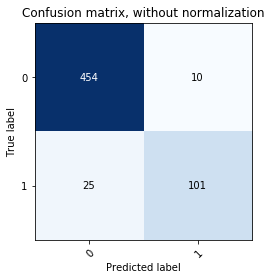

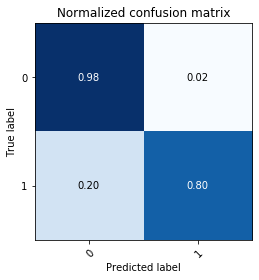

In [62]:
get_confusion_matrix(y_test=test[LABEL_COLUMN],predicted=test_final_labels,labels=label_list_text)

In [63]:
test['predicted_labels']= test_final_labels

In [155]:
test[(test['predicted_labels']==0) & (test['is_covid']==1)]

,sID,Input.text,is_stressor,is_stressor_conf,is_covid,is_covid_conf,top_label,second_label,avg_severity,median_severity,SD_severity,Votes,Work,"Health, Fatigue, or Physical Pain",Other,Emotional Turmoil,Everyday Decision Making,Family Issues,Social Relationships,Financial Problem,School,Source,class_freq,predicted_labels
11,3765,Trying to find things that are sold out at stores.,1,80.00%,1,60.00%,Other,Social Relationships,3.6,3,2.33,6,0.0,0.0,0.5,0.0,0.2,0.1,0.2,0.0,0.0,mTurk_synthetic_covid_2,676,0
21,3774,"m job is really stressing me up because it is like there is a likelihood of loosing it,",1,100.00%,1,60.00%,Work,Emotional Turmoil,5.4,5,2.06,6,0.7,0.0,0.0,0.2,0.0,0.0,0.0,0.1,0.0,mTurk_synthetic_covid_2,676,0
23,3811,The uncertainty of the economy,1,100.00%,1,60.00%,Other,Emotional Turmoil,4.2,4,0.98,5,0.0,0.0,0.4,0.4,0.0,0.0,0.0,0.2,0.0,mTurk_synthetic_covid_2,676,0
77,3751,My fajitas came out burnt!,1,80.00%,1,80.00%,Social Relationships,Financial Problem,4.4,5,2.58,5,0.2,0.0,0.2,0.0,0.0,0.0,0.4,0.2,0.0,mTurk_synthetic_covid_2,676,0
115,3769,Money,1,100.00%,1,80.00%,Financial Problem,Emotional Turmoil,4.2,5,1.17,5,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.8,0.0,mTurk_synthetic_covid_2,676,0
139,3734,I just have been trying to work and its hard to find any,1,100.00%,1,60.00%,Emotional Turmoil,Work,4.4,4,2.24,7,0.3,0.0,0.0,0.5,0.0,0.0,0.0,0.2,0.0,mTurk_synthetic_covid_2,676,0
148,3800,I cant stand not having work to do,1,100.00%,1,60.00%,Work,Financial Problem,5.2,4,1.94,7,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,mTurk_synthetic_covid_2,676,0
152,3813,Work is expecting me back and I feel unsafe going back,1,100.00%,1,80.00%,Work,Financial Problem,4.6,5,1.50,7,0.6,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,mTurk_synthetic_covid_2,676,0
153,3749,hours cut at work,1,100.00%,1,60.00%,Work,,5.4,5,2.06,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mTurk_synthetic_covid_2,676,0
160,3856,"Alex's position as an airline pilot worries me, the planes aren't flying often anymore.",1,80.00%,1,60.00%,Work,Emotional Turmoil,3.0,3,1.90,7,0.3,0.0,0.2,0.2,0.0,0.1,0.2,0.0,0.0,mTurk_synthetic_covid_2,676,0


### Exporting test set with probabilities

In [64]:
test, experiment_df = get_test_experiment_df(test)

INFO:tensorflow:Writing example 0 of 590


INFO:tensorflow:Writing example 0 of 590


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i ' ve got lots of work , and no motivation to do it . [SEP]


INFO:tensorflow:tokens: [CLS] i ' ve got lots of work , and no motivation to do it . [SEP]


INFO:tensorflow:input_ids: 101 1045 1005 2310 2288 7167 1997 2147 1010 1998 2053 14354 2000 2079 2009 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 1005 2310 2288 7167 1997 2147 1010 1998 2053 14354 2000 2079 2009 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i ' ve been feeling if ##fy about my graduation . i think i might be missing something . [SEP]


INFO:tensorflow:tokens: [CLS] i ' ve been feeling if ##fy about my graduation . i think i might be missing something . [SEP]


INFO:tensorflow:input_ids: 101 1045 1005 2310 2042 3110 2065 12031 2055 2026 7665 1012 1045 2228 1045 2453 2022 4394 2242 1012 102 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 1005 2310 2042 3110 2065 12031 2055 2026 7665 1012 1045 2228 1045 2453 2022 4394 2242 1012 102 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] hey friend ! this corona ##virus has really been stress ##ing me out with paying my bills . [SEP]


INFO:tensorflow:tokens: [CLS] hey friend ! this corona ##virus has really been stress ##ing me out with paying my bills . [SEP]


INFO:tensorflow:input_ids: 101 4931 2767 999 2023 21887 23350 2038 2428 2042 6911 2075 2033 2041 2007 7079 2026 8236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4931 2767 999 2023 21887 23350 2038 2428 2042 6911 2075 2033 2041 2007 7079 2026 8236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i ' m stressed out about co ##vid - 19 and its ' impact on the us . [SEP]


INFO:tensorflow:tokens: [CLS] i ' m stressed out about co ##vid - 19 and its ' impact on the us . [SEP]


INFO:tensorflow:input_ids: 101 1045 1005 1049 13233 2041 2055 2522 17258 1011 2539 1998 2049 1005 4254 2006 1996 2149 1012 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 1005 1049 13233 2041 2055 2522 17258 1011 2539 1998 2049 1005 4254 2006 1996 2149 1012 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] my relationship with my best friend . i like him . [SEP]


INFO:tensorflow:tokens: [CLS] my relationship with my best friend . i like him . [SEP]


INFO:tensorflow:input_ids: 101 2026 3276 2007 2026 2190 2767 1012 1045 2066 2032 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2026 3276 2007 2026 2190 2767 1012 1045 2066 2032 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


[101, 1045, 1005, 2310, 2288, 7167, 1997, 2147, 1010, 1998, 2053, 14354, 2000, 2079, 2009, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./models/25_06_2020/test_covid/model.ckpt-486


INFO:tensorflow:Restoring parameters from ./models/25_06_2020/test_covid/model.ckpt-486


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [65]:
experiment_df.to_csv(EXPERIMENTS_PATH+'/test_with_probabilities_covid.csv')

In [258]:
experiment_df

,sID,Input.text,is_stressor,is_stressor_conf,is_covid,is_covid_conf,top_label,second_label,avg_severity,median_severity,SD_severity,Votes,Work,"Health, Fatigue, or Physical Pain",Other,Emotional Turmoil,Everyday Decision Making,Family Issues,Social Relationships,Financial Problem,School,Source,class_freq,Predicted,0,1
0,2823,this project that im working on,0,60.00%,0,100.00%,Other,Work,1.6,0,2.06,7,0.4,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.1,popbots_live,3195,0,0.993305,0.006695
1,1054,i haven't been able to find work and things are going bad with school.,1,100.00%,0,100.00%,Work,School,6.0,6,1.79,9,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.4,mTurk_synthetic,3195,0,0.992486,0.007514
2,105,Being quarantined in my home because of a widespread infectious disease...,1,100.00%,1,100.00%,Emotional Turmoil,"Health, Fatigue, or Physical Pain",4.0,4,1.79,7,0.0,0.3,0.1,0.5,0.0,0.0,0.1,0.0,0.0,mTurk_synthetic_covid,676,1,0.004834,0.995166
3,2849,tires,1,60.00%,0,100.00%,Other,Financial Problem,2.2,1,2.64,6,0.0,0.0,0.4,0.1,0.2,0.0,0.1,0.2,0.0,popbots_live,3195,0,0.979835,0.020165
4,817,i had to deal with a customer today,1,80.00%,0,100.00%,Work,Financial Problem,2.6,1,2.87,6,0.5,0.0,0.1,0.0,0.0,0.0,0.2,0.2,0.0,mTurk_synthetic,3195,0,0.990568,0.009432
5,639,"i am stressed out financially, i am worried about paying my bills.",1,100.00%,0,100.00%,Financial Problem,,6.0,6,1.67,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,mTurk_synthetic,3195,0,0.983374,0.016626
6,1688,making a decision on preschool,1,100.00%,0,100.00%,Family Issues,School,3.8,3,1.47,6,0.0,0.0,0.0,0.0,0.2,0.5,0.0,0.0,0.3,popbots_live,3195,0,0.978268,0.021732
7,916,i have been sressing about not getting enough hits on turk,1,100.00%,0,100.00%,Financial Problem,Work,2.6,3,1.02,7,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,mTurk_synthetic,3195,0,0.988213,0.011787
8,1196,i wont be able to see william,1,60.00%,0,100.00%,Social Relationships,Other,2.6,2,2.65,6,0.0,0.0,0.4,0.1,0.0,0.1,0.4,0.0,0.0,popbots_live,3195,1,0.065221,0.934779
9,3787,i have urgent some work unable come on time,1,100.00%,0,60.00%,Work,Emotional Turmoil,4.6,6,1.96,5,0.8,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,mTurk_synthetic_covid_2,3195,0,0.994409,0.005591


### RUN ALL CELLS ABOVE ON HERE

In [151]:
experiment_df[experiment_df['Predicted'] != experiment_df['Answer.Label']].head(10) # change head(n) to see more  

KeyError: 'Answer.Label'

# Exporting the model as Pb format

In [39]:
def export_model(dir_path):
    MAX_SEQ_LEN = 32
    def serving_input_receiver_fn():
        """An input receiver that expects a serialized tf.Example."""
        reciever_tensors = {
            "input_ids": tf.placeholder(dtype=tf.int32,
                                        shape=[1, MAX_SEQ_LEN])
        }
        features = {
            "label_ids":tf.placeholder(tf.int32, [None], name='label_ids'),
            "input_ids": reciever_tensors['input_ids'],
            "input_mask": 1 - tf.cast(tf.equal(reciever_tensors['input_ids'], 0), dtype=tf.int32),
            "segment_ids": tf.zeros(dtype=tf.int32,
                                    shape=[1, MAX_SEQ_LEN])
            
        }
        return tf.estimator.export.ServingInputReceiver(features, reciever_tensors)

    estimator._export_to_tpu = False
    estimator.export_saved_model(dir_path, serving_input_receiver_fn)

In [40]:
export_model('./tfmodel_covid/pbformat/')

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from ./models/02_07_2020/test_covid/model.ckpt-362


INFO:tensorflow:Restoring parameters from ./models/02_07_2020/test_covid/model.ckpt-362


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets written to: ./tfmodel_covid/pbformat/temp-b'1593772280'/assets


INFO:tensorflow:Assets written to: ./tfmodel_covid/pbformat/temp-b'1593772280'/assets


INFO:tensorflow:SavedModel written to: ./tfmodel_covid/pbformat/temp-b'1593772280'/saved_model.pb


INFO:tensorflow:SavedModel written to: ./tfmodel_covid/pbformat/temp-b'1593772280'/saved_model.pb


## Getting analysis for a another dataset

In [207]:
test_all_live = pd.read_csv(PATH+'out_of_tokens.csv')

test_all_live, experiment_df_live = get_test_experiment_df(test_all_live)

INFO:tensorflow:Writing example 0 of 23


INFO:tensorflow:Writing example 0 of 23


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] george floyd ##s death [SEP]


INFO:tensorflow:tokens: [CLS] george floyd ##s death [SEP]


INFO:tensorflow:input_ids: 101 2577 12305 2015 2331 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2577 12305 2015 2331 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i am making sci ##art and i am very stressed out [SEP]


INFO:tensorflow:tokens: [CLS] i am making sci ##art and i am very stressed out [SEP]


INFO:tensorflow:input_ids: 101 1045 2572 2437 16596 8445 1998 1045 2572 2200 13233 2041 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2572 2437 16596 8445 1998 1045 2572 2200 13233 2041 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i am overwhelmed by this george floyd ' s situation [SEP]


INFO:tensorflow:tokens: [CLS] i am overwhelmed by this george floyd ' s situation [SEP]


INFO:tensorflow:input_ids: 101 1045 2572 13394 2011 2023 2577 12305 1005 1055 3663 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2572 13394 2011 2023 2577 12305 1005 1055 3663 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] anti ##fa is really starting to worry me [SEP]


INFO:tensorflow:tokens: [CLS] anti ##fa is really starting to worry me [SEP]


INFO:tensorflow:input_ids: 101 3424 7011 2003 2428 3225 2000 4737 2033 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3424 7011 2003 2428 3225 2000 4737 2033 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] anti ##fa riot ##ers are burning things [SEP]


INFO:tensorflow:tokens: [CLS] anti ##fa riot ##ers are burning things [SEP]


INFO:tensorflow:input_ids: 101 3424 7011 11421 2545 2024 5255 2477 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3424 7011 11421 2545 2024 5255 2477 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


[101, 2577, 12305, 2015, 2331, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./models/18_06_2020/test_covid/model.ckpt-244


INFO:tensorflow:Restoring parameters from ./models/18_06_2020/test_covid/model.ckpt-244


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [208]:
experiment_df_live

,sID,Input.text,Predicted,0,1
0,1,George Floyds death,0,0.958745,0.041256
1,2,I am making sciart and I am very stressed out,1,0.198503,0.801497
2,3,I am overwhelmed by this George Floyd's situation,0,0.941792,0.058208
3,4,Antifa is really starting to worry me,0,0.984872,0.015128
4,5,Antifa rioters are burning things,0,0.973173,0.026827
5,6,This racism has me stressed.,0,0.987447,0.012553
6,7,"the looting is bothering me a lot, when will it pass my God",0,0.804044,0.195956
7,8,i am stressed that Biden will lose,1,0.161530,0.838470
8,9,This antifas got me stressed bad,0,0.995177,0.004823
9,10,my puppy getting her shots,0,0.998185,0.001815
